In [106]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [107]:
ratings_path = "/Users/amitnarang/Downloads/ml-latest-small/ratings.csv"

In [110]:
df = pd.read_csv(ratings_path, sep = ',')
columns=["userId", "movieId", "rating"]
print(df)
n_users = max(df['userId'])
n_items = max(df['movieId'])
ratings = np.zeros((n_users, n_items))
data = []
for row in df.itertuples():
    if row.userId == 1:
        data.append([row.userId, row.movieId, row.rating])
    else:
        ratings[row.userId - 1, row.movieId - 1] = row.rating
stream_df = pd.DataFrame(data=data, columns=columns)
print(ratings)
print(stream_df)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]
     userId  movieId  rating
0         1        1     4.0
1         1        3     4.0
2         1        6     4.0
3         1       47     5.0
4         1       50     5.0
..      ...      ...     ...
227       1     3744     4.0
228       1     3793 

In [111]:
def create_split(stream_df):
    """
    split into train and test sets
    User vectors 
    
    train vectors on the ratings matrix
    no need to test
    
    then train the user vectors with the streaming update, test on test set
    
    then call it on the train data for those new users and the test data for those users
    """
    test_data = np.zeros((n_users, n_items))
    data = []
    for userId in stream_df["userId"].unique():
        user_df = stream_df[stream_df["userId"] == userId]
        random_five = user_df.sample(5)
        for row in user_df.itertuples():
            if any(random_five["movieId"] == row.movieId):
                test_data[row.userId - 1, row.movieId - 1] = row.rating
            else:
                data.append([row.userId, row.movieId, row.rating])
    train_df = pd.DataFrame(data=data, columns=columns)
    
    return test_data, train_df
    
    '''
    train = np.zeros(ratings.shape) 
    
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 5, replace = False)

        train[user, None] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    return train, test'''

test, train_df = create_split(stream_df)
train_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
222,1,3744,4.0
223,1,3793,5.0
224,1,3809,4.0
225,1,4006,4.0


In [112]:
class ALSModel:
    def __init__(self, l, num_features, n_iters):
        self.l = l
        self.num_features = num_features
        self.n_iters = n_iters
        
    def fit(self, train):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.num_features))
        self.item_factors = np.random.random((self.n_item, self.num_features))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)  
        for i in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
        return self 
    
    def fit_stream(self, ratings, test, train_df):
        '''
        when ratings stream in, add them to the rating matrix
        run ALS update for user vector on entire rating matrix 
        test on test matrix
        compute mse, add to list
        '''
        self.test_mse_record  = []
        for row in train_df.itertuples():
            ratings[row.userId - 1, row.movieId - 1] = row.rating
            self.user_factors = self._als_step(ratings, self.user_factors, self.item_factors)
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            self.test_mse_record.append(test_mse)
        
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.num_features) * self.l
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse
        

In [113]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [114]:
als = ALSModel(n_iters = 100, num_features = 100, l = 0.01)

In [115]:
als.fit(ratings)

In [116]:
movie_factors = als.item_factors

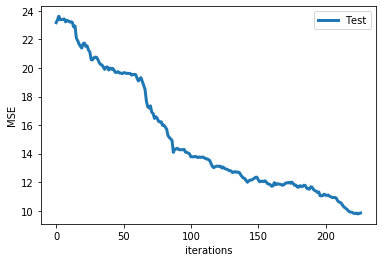

In [117]:
als.fit_stream(ratings, test, train_df)
plot_learning_curve(als)